<div style="display: flex; justify-content: center;">
  <img src="images/unipi_logo.png" style="border-radius: 30px; width: 20%;">
</div>



# <h1><center> Progetto CRAFTY </h1>
<h2><center> Clusterin and scraping for bitcoin deanonymization </h2>
<h3><center> Corso: A.A 2023/2024 </h3>
<h3><center> A cura di Aprile Filippo </h3>
<h3><center> 580175 </h3>

### Introduzione


Lo scopo del progetto risiede nell’implementazione di un insieme di analisi e tecniche di deanonimizzazione applicate ad uno snapshot della blockchain di **Bitcoin**, contenente una selezione di transazioni nel periodo che va dal **03-01-2009** al **31-12-2012**. Il progetto è strutturato nelle seguenti sezioni:
1. **Analisi dataset**
    - Plotting distribuzione del numero di transazioni per blocco nell’intero periodo temporale considerato.
    - Plotting evoluzione dell'occupazione dei blocchi nel tempo, considerando intervalli temporali di due mesi.
    - Calcolo ammontare totale UTXO al momento dell’ultima transazione registrata.
    - Plotting distribuzione degli intervalli di tempo che intercorrono tra generazione UTXO e relativa spesa.
    - Analisi a scelta:
        - Plotting correlazione tra avg_fee e tx_count (chain congesiton) su frame temporali giornalieri.
        - Plotting correlazione tra avg_fee_percentage e tx_count (chain congesiton) su frame temporali giornalieri.
        - Plotting matrice correlazione date, avg_fee_percentage, avg_fee e tx_count.
2. **Clusterizzazione indirizzi bitcoin e relative analisi**
    - Generazione cluster indirizzi tramite _common input heuristic_
    - Analisi cluster
3. **Deanonimizzazione cluster indirizzi**
    - Scraping walletExplorer
    - Scraping bitcoinInfoCharts
    - Deanonimizzazione top 10 cluster
        - WalletExplorer
        - Bitcoininfocharts
    - Confronto tra WalletExplorer e Bitcoininfochart
4. Testing del progetto mediante **script**

In ogni sezione viene illustato come sono state implementate le corrispettive richieste.

#### Setup dataset (**importante**)

Al fine di ottenere una corretta esecuzione da parte del notebook/script è richiesto di inserire il dataset all'interno della folder **data/** come operazione preliminare.

### 1. Analisi dataset

In questa sezione viene illustrata l'implementazione delle analisi richieste nel progetto. Sono state utilizzate le seguenti librerie:
- **pandas**, per leggere csv e manipolare dataframe
- **matplotlib.pyplot**, per il plotting dei grafici
- **seaborn**, per il plotting della matrice di correlazione (analisi a scelta dello studente)



Inizialmente viene eseguita la lettura dei dataset utilizzati successivamente per le analisi tramite la funzione <code> pd.read_csv()</code> offerta dalla libreria _pandas_: 
- transactions.csv
- inputs.csv
- outputs.csv

In [2]:
import pandas as pd

df_transactions = pd.read_csv("../data/transactions.csv", names=["timestamp", "block_id", "tx_id", "is_coinbase", "fee"])
df_transactions.head()

,timestamp,block_id,tx_id,is_coinbase,fee
0,1231473279,9,9,1,0
1,1231635654,78,78,1,0
2,1231731025,170,171,0,0
3,1231740133,181,183,0,0
4,1231740736,182,185,0,0


In [3]:
df_inputs = pd.read_csv("../data/inputs.csv", names=["tx_id", "prev_tx_id", "prev_tx_pos"])
df_inputs.head()

,tx_id,prev_tx_id,prev_tx_pos
0,171,9,0
1,183,171,1
2,185,183,1
3,187,185,1
4,192,187,0


In [4]:
df_outputs = pd.read_csv("../data/outputs.csv", names=["tx_id", "position", "address_id", "amount", "script_type"])
df_outputs.head()

,tx_id,position,address_id,amount,script_type
0,9,0,9,5000000000,1
1,78,0,78,5000000000,1
2,171,0,171,1000000000,1
3,171,1,9,4000000000,1
4,183,0,183,1000000000,1


#### 1.1 Plotting distribuzione del numero di transazioni per blocco nell’intero periodo temporale considerato

- Raggruppamento transazioni per **block_id**, per ogni gruppo viene salvato il numero di transazioni. Risultato salvato in nuovo dataframe **df_distribution**.

- Creazione di 2 istogrammi mediante <code>plt.hist()</code> per plottare la distribuzione del numero di transazioni per blocco, dove:

    - il primo usa una  _scala lineare_ per la frequenza (**left**)
    - il secondo usa invece una _scala logaritmica_, al fine di avere una migliore visualizzazione (**right**)



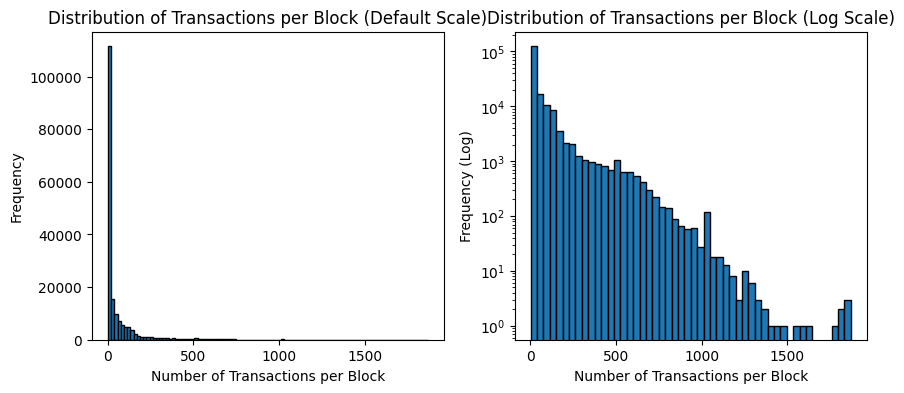

In [5]:
import matplotlib.pyplot as plt

def plot_tx_distribution_by_block(df_transactions):
    
    # Raggrupo le transazioni per block id e conto le righe contentunte da ogni gruppo (equivale a contate le tx per blocco), infine ottengo nuovo dataframe con reset_index()
    df_distribution = df_transactions.groupby("block_id").size().reset_index(name="transaction_count")

    plt.figure(figsize=(10, 4))

    # Plot istogramma utilizzando scala default 
    plt.subplot(1, 2, 1)
    plt.hist(df_distribution["transaction_count"], bins=100, edgecolor='black')
    plt.title("Distribution of Transactions per Block (Default Scale)")
    plt.xlabel("Number of Transactions per Block")
    plt.ylabel("Frequency")

    # Plot utilizzando scala logaritmica per frequenza
    plt.subplot(1, 2, 2)
    plt.hist(df_distribution["transaction_count"], bins=50, edgecolor='black')
    plt.yscale('log')  # Setto asse y in scala logarimica per avere una migliore visualizzazione
    plt.title("Distribution of Transactions per Block (Log Scale)")
    plt.xlabel("Number of Transactions per Block")
    plt.ylabel("Frequency (Log)")

    # Plotto entrambi i grafici
    plt.show()
    
plot_tx_distribution_by_block(df_transactions)

#### 1.2 Plotting evoluzione dell'occupazione dei blocchi nel tempo, considerando intervalli temporali di due mesi

- Conversione timestamp unix del dataframe **df_transactions** a datetime object _pandas_

- Raggruppamento transazioni per **block_id**, per ogni gruppo viene salvato:
    - **tx_count**, numero transazioni contenute nel blocco
    - **timestamp**, timestamp del blocco. Viene preso il timestamp della prima transazioni in quanto il timestamp è relativo al blocco e quindi transazioni appartenenti allo stesso hanno lo stesso timestamp. Sarebbe stato equivalente prendere l'ultimo o prenderlo da un transazione randomica del blocco.
    
    Il risultato viene salvato in nuovo dataframe **df_blocks**.

- Cambiamento giorno del primo blocco dal 09-01-2009 allo 01-09-2009 al fine di definire correttamente i periodi di 2 mesi tramite la <code>pd.Grouper()</code> usata successivamente

- Raggruppamento blocchi per periodi temporali di 2 mesi utilizzando <code>pd.Grouper(key='timestamp', freq='2ME')</code>, per ogni gruppo viene salvata la media del numero delle transazioni dei blocchi appartenenti a quest'ultimo.
    
    Il risultato viene salvato in **df_blocks** sovrascrivendolo.

- Creazione di un line plot mediante <code>plt.plt()</code>, avente:
    - **asse x**, periodi temporali di 2 mesi
    - **asse y**, media del numero delle transazioni dei blocchi nel periodo considerato

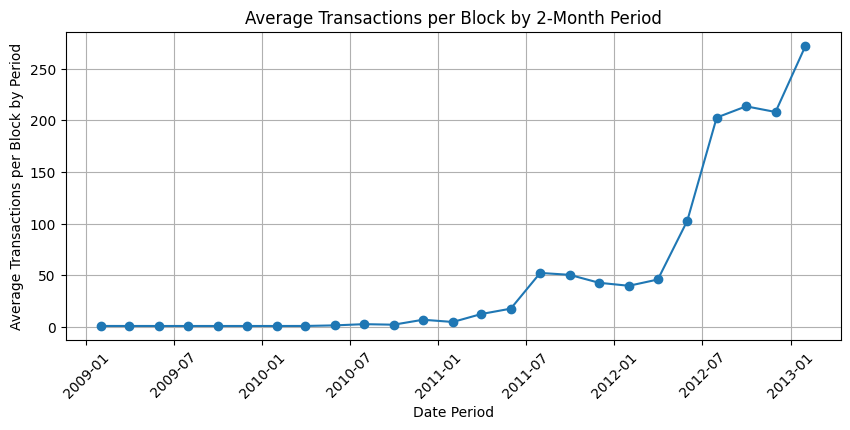

In [6]:
def average_tx_by_block_2_month_period(df_transactions):

    # converto i timestamp in datetime
    df_transactions['timestamp'] = pd.to_datetime(df_transactions['timestamp'], unit='s')

    # Raggrupo le transazioni per block id e ottengo due nuove colonne nel df risultante:
    #   - tx_count = numero di transazioni contenuto in quel blocco
    #   - timestamp = timestamp del blocco (dato che il timestamp è del blocco tutte le transazioni appartenenti allo stesso blocco hanno le stesso timestamp quindi prendo il primo)
    df_blocks = df_transactions.groupby('block_id').agg(
        tx_count=('tx_id', 'size'),
        timestamp=('timestamp', 'first')  
    ).reset_index()
    
    # Cambio il giorno della prima transazione dal 9-01-2009 al 01-01-2009 affinchè la Grouper definisca correttamente i periodi di 2 mesi (primo periodo che va dal 1 jan a 28 feb)
    df_blocks.loc[0, 'timestamp'] = df_blocks.loc[0, 'timestamp'].replace(day=1)
    
    # Raggrupo i blocchi per periodi di due mesi tramite il timestamp e ottengo la media di tutte le transazioni per blocco per ogni periodo
    df_blocks = df_blocks.groupby(pd.Grouper(key='timestamp', freq='2ME'))['tx_count'].mean().reset_index(name= "avg_tx_count") 
    
    plt.figure(figsize=(10, 4))
    plt.plot(df_blocks["timestamp"], df_blocks["avg_tx_count"], marker='o', linestyle='-')
    
    plt.xlabel('Date Period')
    plt.ylabel('Average Transactions per Block by Period')
    plt.title('Average Transactions per Block by 2-Month Period')
    plt.grid(True) # setto grid True al fine di migliorare la visualizzazione
    plt.xticks(rotation=45) # ruoto label asse x a 45 gradi per evitare che si sovrappongano
    
    # Plotto il grafo ottenuto
    plt.show()
    
average_tx_by_block_2_month_period(df_transactions)

#### 1.3 Calcolo ammontare totale UTXO al momento dell’ultima transazione registrata

- Esecuzione left merge tra **df_outputs** e **df_inputst**, utilizzando le seguenti colonne:
    - **df_outputs**, coppia (_tx_id_, _position_)
    - **df_inputst**, coppia (_prev_tx_id_, _prev_tx_pos_)
    
    Le righe ottenute nel dataframe risultante con indicator= _left_only_ saranno gli output che non hanno trovato corrispenza negli input, ovvero le UTXO.

- Filtrazione degli output sul dataframe risultante tenenedo solo quelli relativi a UTXO utilizzando condizione precedentemnte descritta (indicator= _left_only_)

- Calcolo ammontare totale UTXO mediante funzione <code>sum()</code> apllicata alla colonna _amount_ del dataframe. 

    Il risultato viene infine convertito da satoshi a BTC

- Calcolo totale UTXO ottenuto dalla lunghezza del dataframe risultante

In [7]:
def get_total_utxos(df_inputs, df_outputs):  
    
    # Eseguo la left merge tra df_outputs e df_inputs confrontando la coppia ['tx_id', 'position'] output con la coppia ['prev_tx_id', 'prev_tx_pos'] associando cosi ad ogni output l'input che l'ha speso, NaN altrimenti
    utxo_df = pd.merge(df_outputs, df_inputs, left_on=['tx_id', 'position'], right_on=['prev_tx_id', 'prev_tx_pos'], how='left', indicator=True)
    # Filtro ora solo per gli output che non hanno corrispondenza negli input (prendendo solo le righe con indicator "left_only") ottenendo cosi tutti le UTXO
    utxo_df = utxo_df[utxo_df['_merge'] == 'left_only'].drop('_merge', axis=1)
    # Ottengo ammontare totale UTXO facendo la somma di tutti gli amount e converto satoshi in btc (1 btc = 100000000 satoshi)
    total_amount_utxo_btc = (utxo_df['amount'].sum())/100000000
    # Ottengo inoltre il numero totale di UTXO
    utxo_count = len(utxo_df)
    
    # Restituisco valori ottenuti
    return total_amount_utxo_btc, utxo_count

total_amount_utxo_btc, utxo_count = get_total_utxos(df_inputs, df_outputs)
print(f"Trovate {utxo_count} utxos per un ammontare totale di {total_amount_utxo_btc:.2f} btc")

Trovate 3194301 utxos per un ammontare totale di 8593033.73 btc


#### 1.4 Plotting distribuzione degli intervalli di tempo che intercorrono tra generazione UTXO e relativa spesa

- Esecuzione inner merge tra **df_outputs** e **df_inputst**, utilizzando le seguenti colonne:
    - **df_outputs**, coppia (_tx_id_, _position_)
    - **df_inputst**, coppia (_prev_tx_id_, _prev_tx_pos_)
    
    Le righe ottenute nel dataframe risultante, **df_stxo**, saranno gli output che hanno trovato corrispondenza negli input, ovvero le STXO.

- Rinominazione e filtrazione colonne **df_stxo** tenendo solo _output_tx_id_ e _input_tx_id_, usate successivamente per recuperare **timestamp creazione** e **timestamp spesa** 

- Filtrazione colonne **df_transactions** tenendo solo _tx_id_ e _timestamp_, sempre per recuperare **timestamp creazione** e **timestamp spesa**. Risultato salvato nel dataframe **reduced_df_transactions**  

- Esecuzione inner merge tra **df_stxo** e **reduced_df_transactions**, utilizzando le seguenti colonne:
    - **df_stxo**, _output_tx_id_
    - **reduced_df_transactions**, _tx_id_
    
    Ne risulta un nuova colonna contentente per ogni output (row) il timestamp di creazione.
    Il risultato viene salvato in **df_stxo** sovrascrivendolo.

- Esecuzione inner merge tra **df_stxo** e **reduced_df_transactions**, utilizzando le seguenti colonne:
    - **df_stxo**, _input_tx_id_
    - **reduced_df_transactions**, _tx_id_
    
    Ne risulta un nuova colonna contentente per ogni output (row) il timestamp di spesa.
    Il risultato viene nuovamente salvato in **df_stxo** sovrascrivendolo.

- Conversione _timestamp creazione_ e _timestamp spesa_ da unix timestamp a datetime object _pandas_

- Aggiunta di una nuova colonna _delta_time_days_ a **df_stxo** contente la distanza in gioni tra la creazione di un UTXO e la sua spesa, ottenuta mediante <code>(df_stxo["timestamp_spent"] - df_stxo["timestamp_creation"]).dt.days</code>

- Creazione istogramma mediante <code>plt.hist(df_stxo["delta_time_days"], bins=20, edgecolor='black')</code> per plottare distribuzione degli intervalli di tempo giornalier che intercorrono tra generazione UTXO e la sua spesa


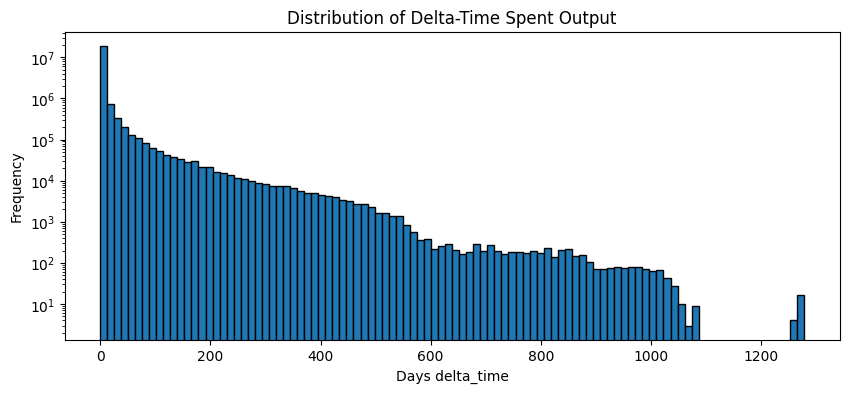

In [8]:
def plot_utxo_distribution_by_time_to_spent(df_inputs, df_outputs, df_transactions):     
    
    # Eseguo la inner merge tra df_outputs e df_inputs ottenendo solo gli output spesi (stxo) (in quanto inner == intersezione e il controllo restituisce solo gli output la cui coppia ['tx_id', 'position'] risulta presente in input ['prev_tx_id', 'prev_tx_pos']
    df_stxo = pd.merge(df_outputs, df_inputs, left_on=['tx_id', 'position'], right_on=['prev_tx_id', 'prev_tx_pos']).reset_index()
    # Rinomino le colonne del df ottentuto
    df_stxo = df_stxo.rename({"tx_id_x": "output_tx_id", "tx_id_y": "input_tx_id"}, axis= "columns")
    # Filtro lasciando solo le colonne contenenti output_tx_id (risalire alla generazione) e input_tx_id (risalire alla spesa)
    df_stxo = df_stxo[["output_tx_id", "input_tx_id"]]
    # Ottengo un df_transaction ridotto con le uniche colonne di cui necessito ovvero tx_id per la merge e timestamp per ottenere timestamp generazione utxo e timestamp spesa (stxo)
    reduced_df_transactions = df_transactions[["tx_id", "timestamp"]]
    # Eseguo una prima merge su "output_tx_id" (df_stxo) e "tx_id" (reduced_df_transactions) per ottenere i timestamp di generazione di ogni output
    df_stxo = pd.merge(df_stxo, reduced_df_transactions, left_on=['output_tx_id'], right_on=['tx_id']).rename({"timestamp": "timestamp_creation"}, axis= "columns").drop("tx_id", axis=1)
    # Eseguo una seconda merge su "input_tx_id" (df_stxo) e "tx_id" (reduced_df_transactions) per ottenere invece i timestamp di spesa di ogni output
    df_stxo = pd.merge(df_stxo, reduced_df_transactions, left_on=['input_tx_id'], right_on=['tx_id']).rename({"timestamp": "timestamp_spent"}, axis= "columns").drop("tx_id", axis=1)
    # Converto timestamp generazione e spesa a datetime
    df_stxo['timestamp_creation'] = pd.to_datetime(df_stxo['timestamp_creation'], unit='s')
    df_stxo['timestamp_spent'] = pd.to_datetime(df_stxo['timestamp_spent'], unit='s')
    # Aggiungo un nuova colonna "delta_time_days" dove salvare la differenza (in giorni) tra timestamp generazione e timestamp spesa
    df_stxo["delta_time_days"] = (df_stxo["timestamp_spent"] - df_stxo["timestamp_creation"]).dt.days
    # Plot istogramma utilizzando scala logaritmica
    plt.figure(figsize=(10, 4))
    
    plt.hist(df_stxo["delta_time_days"], bins=100, edgecolor='black')
    plt.title("Distribution of Delta-Time Spent Output")
    plt.xlabel("Days delta_time")
    plt.ylabel("Frequency")
    plt.yscale('log')  # Setto asse y in scala logarimica al fine di ottenere una migliore visualizzazione
    
    plt.show()

plot_utxo_distribution_by_time_to_spent(df_inputs, df_outputs, df_transactions)

#### 1.5 Analisi a scelta

Come analisi a scelta è stato voluto visualizzare il **comportamento delle fee delle transizoni rispetto alla chain congestion (numero di transazioni) in frame temporali giornalieri**, al fine di verificare se _all' aumentare della congestione aumentino anche le fee_ (come accade sulla blockchain di **ethereum**). Per fare ciò è stato ottenuto un dataframe contenente per ogni frame giornaliero:
- **numero di transazioni**
- **average fee delle transazioni** 
- **average fee percentage delle transazioni**, ovvero ammontare in percentuale della fee rispetto al totale speso.

Non sono state considerate le transazione coinbase (numero input = 0).

Per la visualizzazione vengono plottati tre grafici:   
- **Comparison between chain congestion and avg fee in daily frame**, twin plot in cui vengono sovrapposti il plot delle numero di transazioni e quello dell' average fee rispetto ai frami giornalieri
- **Comparison between chain congestion and avg fee percentage in daily frame**, twin plot in cui vengono sovrapposti il plot delle numero di transazioni e quello dell' average fee percentage rispetto ai frami giornalieri
- **Chain Congestion, Avg Fee Percentage e Avg Fee**, matrice correlazione tra numero transazioni, average fee percentage e average fee sempre rispetto ai frami giornalieri tramite uso della libreria _seaborn_


##### 1.5.1 Costruzione dataframe correlazione usato per i successivi plot

- Esecuzione inner merge tra **df_inputst** e **df_outputs**, utilizzando le seguenti colonne:
    - **df_inputst**, coppia (_prev_tx_id_, _prev_tx_pos_);
    - **df_outputs**, coppia (_tx_id_, _position_).
    
    Le righe ottenute nel dataframe risultante, **input_df**, saranno gli input estesi con l'output che stanno spendendo, STXO.

- Rinominazione e filtrazione colonne **input_df** tenendo solo quelle utili al fine dell' analisi: _tx_id_ e _input_amount_.

- Raggruppamento input per **tx_id**, per ogni gruppo viene salvato il **tx_input_amount**, ovvero totale speso dalla transazione.
    
    Il dataframe risultante conterrà una riga per ogni transazione con il corrispettivo amount speso.
    
    Risultato salvato in **input_df** sovrascrivendolo.

- Filtrazione colonne **df_transactions** tenendo solo quelle utili al fine dell' analisi: _tx_id_ e _fee_ e _timestamp_.
    La colonna _tx_id_ viene usata per il merge con **input_df**

- Esecuzione inner merge tra **df_stxo** e **reduced_df_transactions** su colonna _tx_id_.
    
    Nel dataframe risultante ogni transazione viene estesa con corrispettivo/a: fee e timestamp.
    
    Risultato salvato in **df_stxo** sovrascrivendolo.

- Conversione **input_df['timestamp']** da unix timestamp a datetime object _pandas_, con conseguente rinominazione colonna a **'date'**.

- Aggiunta **input_df["fee_percentage"]** dove viene salvato ammontare fee in percentuale rispetto a totale speso per ogni transazione.

- Raggruppamento transazioni in frame temporali giornalieri tramite <code>pd.Grouper(key='date', freq='D')</code>, per ogni gruppo vengono salvati:
    - **avg_fee**, media fee transazione contenute nel gruppo
    - **avg_fee_percentage**, media percentuale fee contenute nel gruppo
    - **tx_count**, numero di transazioni
    
    Il dataframe risultante conterrà una riga per ogni giorno con corrispettivo/a: data, avg_fee , avg_fee_percentage e tx_count giornalieri.
    
    Risultato salvato in **input_df** sovrascrivendolo.



In [9]:
def get_correlation_df(df_inputs, df_outputs, df_transactions):   
    # Eseguo la merge tra df_inputs e df_outputs sulle coppie ("prev_tx_id", "prev_tx_pos") e ("tx_id", "position") per estendere ogni input con l'output speso da esso
    input_df = pd.merge(df_inputs, df_outputs, left_on=['prev_tx_id', 'prev_tx_pos'], right_on=['tx_id', 'position'])
    # Filtro il df ottenuto dalla merge prendendo solo le colonne "tx_id_x" e "amount" e le rinomino
    input_df = input_df[["tx_id_x", "amount"]].rename({"tx_id_x": "tx_id", "amount": "input_amount"}, axis= "columns")
    # Raggrupo gli input per "tx_id" ottenendo un df con un riga per ogni transazione con il corrispetivo amount totale, nominando la colonna ottenuta "tx_input_amount"
    input_df = input_df.groupby("tx_id")["input_amount"].sum().reset_index(name = "tx_input_amount")
    # Filtro il df delle transazioni prendendo solo le colonne di cui necessito per l'analisi: "tx_id", "fee", "timestamp"
    reduced_df_transactions = df_transactions[["tx_id", "fee", "timestamp"]]
    # Eseguo la merge tra input_df e reduced_df_transactions su "tx_id" per estendere le transizioni con la loro fee e il loro timestamp, riordinando le righe ottenuto per timestamp (crescente)
    input_df = pd.merge(input_df, reduced_df_transactions, on= "tx_id").sort_values("timestamp")
    # Converto i timestamp in datetime
    input_df['timestamp'] = pd.to_datetime(input_df['timestamp'], unit='s')
    input_df.rename(columns={'timestamp': 'date'}, inplace=True)
    # Calcolo la fee in percentuale rispetto all amount speso per ogni transazione
    input_df["fee_percentage"] = (input_df["fee"] / input_df["tx_input_amount"]) * 100
    # Raggrupo le transazioni per periodi temporali di un giorno tramite la grouper, calcolando per ogni gruppo ottenuto: media delle fee, medie della percentuale delle fee e numero di transazioni
    input_df = input_df.groupby(pd.Grouper(key='date', freq='D')).agg(
        avg_fee=('fee', 'mean'),
        avg_fee_percentage=('fee_percentage', 'mean'), 
        tx_count=('tx_id', 'size'), 
    ).reset_index()
    
    # Rimuovo giorni in cui non vi sono state transazioni 
    input_df = input_df[input_df["tx_count"] > 0]
    
    return input_df

correlation_df = get_correlation_df(df_inputs, df_outputs, df_transactions)
correlation_df.head()

# Rimuovo riferimento a df_transactions in modo che venga deallocato dal gc
df_transactions = None

##### 1.5.2 Plotting correlazione tra avg_fee e tx_count (chain congesiton) su frame temporali giornalieri

- Viene effettuato il plotting sovrapponendo i grafici del numero di transazioni giornaliere con quelle dell'avg fee giornaliera. 

- Si nota che i dati sono scorellati e questo è probabilmente legato all' andamento del prezzo di bitcoin negli anni. Notiamo infatti che la media delle fee presenta picchi sopratutto nel primo anno e mezzo quando btc era ancora in fase sperimentale e non era visto come risorsa di valore.   

- Con l'aumento del prezzo avvenuto negli anni le avg fee si sono ridotte drasticamente.

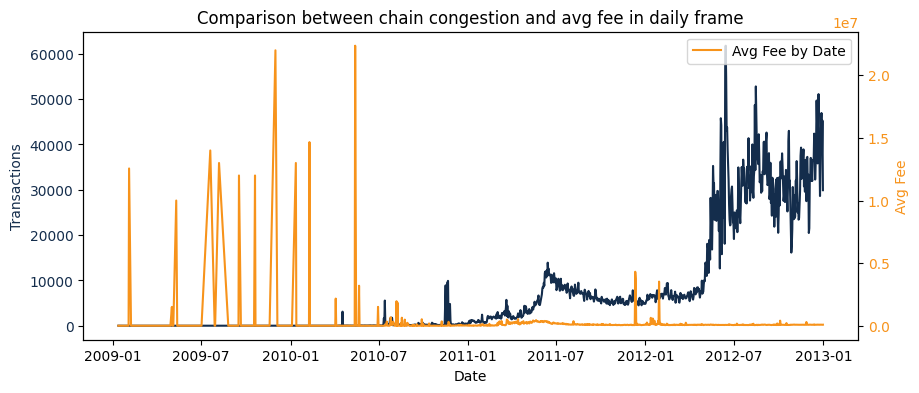

In [10]:
def plot_correliaton_between_avg_fees_and_tx_count(correlation_df):
    
    # Plotting grafico tx_count in frame temporali giornalieri
    fig, ax1 = plt.subplots(figsize=(10, 4))
    ax1.plot(correlation_df["date"], correlation_df["tx_count"], '#142D4C', label='Chain Congestion')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Transactions', color='#142D4C')
    ax1.tick_params(axis='y', labelcolor='#142D4C')
    ax1.set_title('Comparison between chain congestion and avg fee in daily frame')

    # Plotting grarico sovrapposto (condividono asse x ma usano assi y differenti) per avg_fees in frame temporali giornalieri
    ax2 = ax1.twinx()
    ax2.plot(correlation_df["date"], correlation_df["avg_fee"], '#F7931B', label='Avg Fee by Date')
    ax2.set_ylabel('Avg Fee', color='#F7931B')
    ax2.tick_params(axis='y', labelcolor='#F7931B')
    ax2.legend(loc='upper right')
    
    # Plotto il grafo ottenuto
    plt.show()
    
plot_correliaton_between_avg_fees_and_tx_count(correlation_df)

##### 1.5.3 Plotting correlazione tra avg_fee_percentage e tx_count (chain congesiton) su frame temporali giornalieri

- Viene effettuato il plotting sovrappendo i grafici del numero di transazioni giornaliere con quelle dell'avg fee percentage giornaliera. 

- Al contrario del plot precedente qui si nota un alta correllazione. Ne risulta che in btc all' aumentare della congestione della blockchain aumenta la percentuale di fee in media che gli utenti sono disposti a spendere per velocizzare la conferma.

- Comportamento simile a ethereum, nella quale probabilmente la media dell avg fee percentage risulterebbe molto maggiore se preso in considerazione il periodo bolla degli nft.
    Inoltre incrociando i dati ottenuti precedentemente notiamo che anche il totale speso da ogni transazione è andato a ridursi dratiscamente, coerentemente all' andamento prezzo btc.

- A seguito del plotting vengono stampate delle analisi su **correlation_df**, tramite uso di <code>describe()</code> offerta da _pandas_, da cui osserviamo che:
    - la media delle avg_fee_percentual risulta essere 0.4% mentre il max 4.3%. Sarebbe interessante confrontare questi dati con il tempo di conferma della transazione per un eventuale confronto con le fiat.

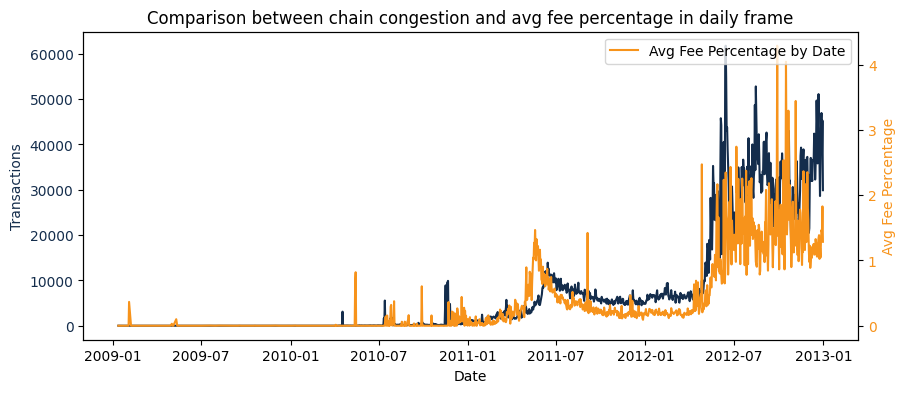

,date,avg_fee,avg_fee_percentage,tx_count
count,1199,1.199000e+03,1199.000000,1199.000000
mean,2011-04-27 02:18:06.905754880,2.235287e+05,0.405695,8639.087573
min,2009-01-12 00:00:00,0.000000e+00,0.000000,1.000000
25%,2010-07-16 12:00:00,0.000000e+00,0.000000,119.000000
50%,2011-05-12 00:00:00,6.001043e+04,0.170306,4513.000000
75%,2012-03-06 12:00:00,8.494528e+04,0.521790,8373.500000
max,2012-12-31 00:00:00,2.236667e+07,4.289786,61782.000000
std,NaN,1.430671e+06,0.593610,12272.369168


In [11]:
def plot_correliaton_between_avg_fees_percentage_and_tx_count(correlation_df):
    
    # Plotting grafico tx_count in frame temporali giornalieri
    fig, ax1 = plt.subplots(figsize=(10, 4))
    ax1.plot(correlation_df["date"], correlation_df["tx_count"], '#142D4C', label='Chain Congestion')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Transactions', color='#142D4C')
    ax1.tick_params(axis='y', labelcolor='#142D4C')
    ax1.set_title('Comparison between chain congestion and avg fee percentage in daily frame')

    # Plotting grafico sovrapposto (condividono asse x ma usano assi y differenti) per avg_fees_percentage in frame temporali giornalieri
    ax2 = ax1.twinx()
    ax2.plot(correlation_df["date"], correlation_df["avg_fee_percentage"], '#F7931B', label='Avg Fee Percentage by Date')
    ax2.set_ylabel('Avg Fee Percentage', color='#F7931B')
    ax2.tick_params(axis='y', labelcolor='#F7931B')
    ax2.legend(loc='upper right')
    
    plt.show()
    
plot_correliaton_between_avg_fees_percentage_and_tx_count(correlation_df)

correlation_df.describe()


##### 1.5.4 Plotting matrice correlazione avg_fee_percentage, avg_fee, tx_count e date

- Infine viene plottata la matrice di correlazione tra:
    - **avg_fee_percentage**
    - **avg_fee**
    - **tx_count**
    - **date**

    , dalla quale si deduce che:
    -  il numero di transazioni giornaliere aumenta nel tempo (maggiore adozione della blockchain)
    -  anche avg_fee_percentage giornaliere aumenta nel tempo, dovute al fenomeno descritto sopra.
    -  avg_fee giornaliere risultano scorrelate da le altre **series**, probailmente legato ai fattoi descritti precendemente: 
        - **andamento prezzo bitcoin**
        - **periodo contentente fase iniziale di testing**
    

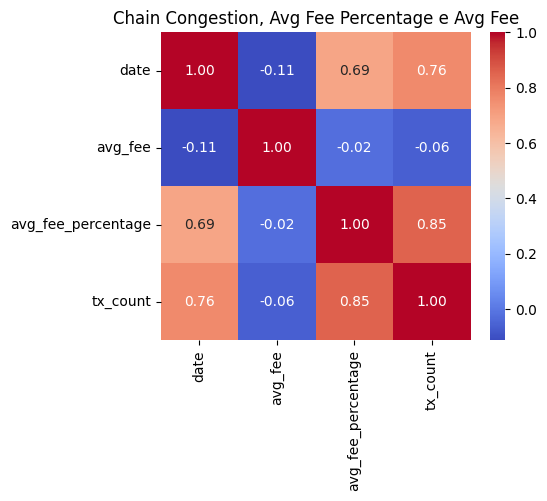

In [12]:
import seaborn as sns

def plot_correlation_matrix(correlation_df):
    
    plt.figure(figsize=(5, 4))
    # Ottengo matrice correlazione relativa a correlation_df
    correlation_matrix = correlation_df.corr()
    # Plotting matrice correlaione realtiva a correlation_df usando seaborn
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Chain Congestion, Avg Fee Percentage e Avg Fee")

    plt.show()
    
plot_correlation_matrix(correlation_df)

# Rimuovo riferimento a correlation_df in modo che venga deallocato dal gc
correlation_df = None

### 2. Clusterizzazione indirizzi bitcoin e relative analisi

Nella seguente sezione viene presentata l'implementazione del clustering degli indirizzi contenuti nella blockchain fornita utilizzando la _common input heuristic_ e vengono eseguite analisi relative sui cluster ottenuti.

Sono state utilizzate le seguenti librerie:
- **networkx**, per generare il grafo degli indirizzi e successivamente clusterizzarli tramite la funzione <code>nx.connected_components()</code>.
- **statistics**, per condurre analisi sui cluster.

#### 2.1 Generazione cluster indirizzi tramite _common input heuristic_

- Esecuzione lettura del dataset **mapping.csv**, contenente associazioni _address_id_ / _hash_

In [13]:
df_mapping = pd.read_csv("../data/mapAddr2Ids8708820.csv", names=["hash", "address_id"])
df_mapping.head()

,hash,address_id
0,1A1zP1eP5QGefi2DMPTfTL5SLmv7DivfNa,0
1,12c6DSiU4Rq3P4ZxziKxzrL5LmMBrzjrJX,1
2,1HLoD9E4SDFFPDiYfNYnkBLQ85Y51J3Zb1,2
3,1FvzCLoTPGANNjWoUo6jUGuAG3wg1w4YjR,3
4,15ubicBBWFnvoZLT7GiU2qxjRaKJPdkDMG,4


- Creazione di un grafo indiretto semplice tramite `nx.Graph()`.

- Aggiunta di nodi per ogni indirizzo presente in **df_mapping["hash"]**.

- Esecuzione di un inner merge tra **df_inputs** e **df_outputs**, utilizzando le seguenti colonne:
    - In **df_inputs**, la coppia (_prev_tx_id_, _prev_tx_pos_);
    - In **df_outputs**, la coppia (_tx_id_, _position_).
    
    Le righe ottenute nel dataframe risultante, chiamato **input_df**, rappresentano gli input estesi con l'output che stanno spendendo, STXO.

- Rinominazione e filtrazione delle colonne di **input_df**, mantenendo solo:
    - **tx_id** 
    - **address_id** 

- Esecuzione di un inner merge tra **input_df** e **df_mapping** sulla colonna _address_id_. Le righe ottenute nel dataframe risultante rappresentano gli input estesi con il corrispondente hash (indirizzo).
    
    Il risultato viene salvato in **input_df**, sovrascrivendo la variabile.
    
    Infine, vengono filtrate le colonne, mantenendo solo: 
    - **tx_id** 
    - **hash**

- Raggruppamento degli input per **tx_id**, ottenendo il corrispondente gruppo di input per ogni transazione.

- Iterazione attraverso tutte le transazioni. Per ognuna viene verificato se ha più di un input (condizione dell'euristica utilizzata).
    
    In caso affermativo:
    - Gli indirizzi degli input della transazione vengono salvati in un set() al fine di rimuovere i duplicati e prevenire **self_loop**.
    - Viene rimosso e salvato nella variabile **first_address** l'indirizzo del primo input.
    - Gli indirizzi dei restanti input vengono iterati, e per ognuno di essi viene creato un arco da **first_address** a quest'ultimo.

- Ottenimento dei clusters, che corrispondono alle **componenti connesse** del grafo, tramite la funzione `nx.connected_components(address_graph)`.

    Il risultato viene salvato all'interno di una lista per poterlo iterare successivamente.


In [14]:
import networkx as nx

def get_address_clusters(df_inputs, df_outputs, df_mapping):
    
    # Creo grafo semplice indiretto
    address_graph = nx.Graph()
    
    # Aggiungo un nodo al grafico per ogni address presente in df_mapping
    address_graph.add_nodes_from(df_mapping["hash"])
    
    # Eseguo inner merge tra df_inputs e df_outputs per estendere ogni input con corrsipettivo output speso da esso
    input_df = pd.merge(df_inputs, df_outputs, left_on=['prev_tx_id', 'prev_tx_pos'], right_on=['tx_id', 'position'])
    
    # Filtro colonne tenendo solo: tx_id_x in e address_id e rinomino tx_id_x in tx_id
    input_df = input_df[["tx_id_x", "address_id"]].rename({"tx_id_x": "tx_id"}, axis= "columns")
    
    # Eseguo inner merge tra input_df e df_mapping in modo da ottenere per ogni input il relativo address tramite la chiave address_id
    input_df = pd.merge(input_df, df_mapping, on= "address_id")[["tx_id", "hash"]]
    
    # Raggrupo gli input per tx_id, in modo da ottenere per ogni transazione il corrispetivo gruoppo di input
    input_grouped_by_tx = input_df.groupby("tx_id")
    
    # Itero i gruppi risultanti da input_df.groupby("tx_id") (ovvero le transazioni)
    for _, group in input_grouped_by_tx:
        
        # Controllo che la transazione abbia più di input
        if len(group) > 1 :
            # Salvo address relativi a input della transazione in un set() in modo da rimuovere duplicati e prevenire formazione di self_loop sul grafo
            addresses = set(group["hash"])
            
            # Rimuovo dal set() ottenuto il primo indirizzo relativo al primo input e lo salvo in "first_address"
            first_address = addresses.pop()
            
            #  Itero gli address relativi ai restanti input e per ognuno creo un arco da first_address ad esso
            for address in addresses:
                address_graph.add_edge(first_address, address)    
    
    # Calcolo le componenti connesse del grafo, le quali corrispondo ai cluster di address risultanti dall' applicazione della "common input heuristic". Infine li salvo in una lista per poterli iterare in seguito
    clusters = list(nx.connected_components(address_graph))
    
    return clusters

clusters = get_address_clusters(df_inputs, df_outputs, df_mapping)

# Rimuovo riferimento a: df_inputs, df_outputs, df_mapping in modo che venga deallocato dal gc
df_inputs, df_outputs, df_mapping = None, None, None

#### 2.2 Analisi cluster

Dall' insieme di cluster ottenuto vengono ricavate le seguenti infomazioni:
- cardinalità
- dimensione massima, media e minima cluster
- mediana dimensione cluster
- deviazione standard dimensione cluster
- distribuzione deimensione dei cluster tramite plottin istogramma con <code>plt.hist(clusters_size, bins=100, alpha=0.7, color='blue', edgecolor='black')</code>


Total clusters found : 4800614
min_size_cluster : 1
max_size_cluster : 259773
average_size_cluster : 1.8141056539850944
median_size : 1.0
std_size : 152.2686354567921


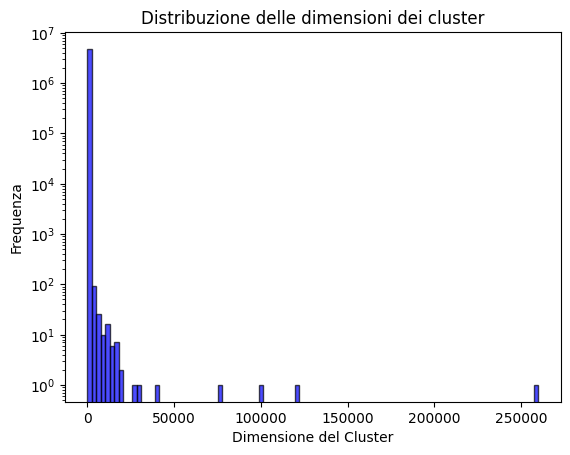

In [15]:
from statistics import mean, median, stdev

def compute_clusters_analysis(clusters):
    
    
    # Stampo numero di cluster ottenuti
    print(f"Total clusters found : {len(clusters)}")
    
    # Calcolo lunghezza di ogni cluster e li salvo in una lista
    clusters_size = [len(cluster) for cluster in clusters]
    min_size = min(clusters_size) 
    # Stampo dimensione minima cluster
    print(f"min_size_cluster : {min_size}")
    max_size = max(clusters_size) 
    # Stampo dimensione massima cluster
    print(f"max_size_cluster : {max_size}")
    average_size = mean(clusters_size) 
    # Stampo dimensione media cluster
    print(f"average_size_cluster : {average_size}")
    median_size = median(clusters_size) 
    # Stampo mediana dimensione cluster
    print(f"median_size : {median_size}")
    std_size  = stdev(clusters_size) 
    # Stampo deviazione standard cluster, al fine di vedere quanto i valori siano sparsi o meno
    print(f"std_size : {std_size}")

    # Plotto istogramma distribuzione della dimensione dei cluster
    plt.hist(clusters_size, bins=100, alpha=0.7, color='blue', edgecolor='black')
    plt.xlabel('Dimensione del Cluster')
    plt.ylabel('Frequenza')
    plt.yscale("log")
    plt.title('Distribuzione delle dimensioni dei cluster')
    plt.show()
    
compute_clusters_analysis(clusters)

### 3. Deanonimizzazione cluster indirizzi

In questa sezione viene presentata l'implementazione per la deanonimizzazione dei 10 cluster di dimensione maggiore effettuata mediante scraping sui seguenti siti:
- [WalletExplorer](https://www.walletexplorer.com)
- [Bitcoininfocharts](https://bitinfocharts.com)

Sono state utilizzate le seguenti librerie:
- **random**, per eseguire selezione randomica di user-agent e introdurre randomness nelle sleep al fine di ottenere un compartamento maggiormente human-like.
- **requests**, per gestire richieste HTTP.
- **BeautifulSoup**, per parsare html e eseguire scraping delle informazioni necessarie.
- **time**, per introdurre delle sleep al fine di mitigare rate-limit.

I 2 siti utilizzano dei meccanismi diversi per prevenire lo scraping:
- **rate-limit by user-agent** (Bitcoininfocharts), il quale viene risolto nel seguente modo:
    - **cambio user-agent per ogni richiesta**, ad ogni richiesta GET viene scelto randomicamente un user-agent dal file users_agents.py, importato dal seguente [github](https://github.com/dusekdan/List-of-User-Agent-Strings-in-Machine-Readable-Formats/blob/master/user-agents-list.py). In questo modo anche se un user agent incorre in rate-limit alla prossima richiesta ne viene selezionato un altro, aggirando il problema.
    - **sleep random (0,5 ,1) tra ogni richiesta**, viene introdotta un sleep randomica (min 0,5 max 1 secondi) al fine di effettuare uno scraping quantomeno etico cercando di utilizzare nel contempo un approccio "best_effort".

- **rate-limit by ip** (WalletExplorer), dopo un tot di richieste, nonostante il continuo cambio di user-agent, si incorre in **http error 429** _too many_request_ ovvero in rate-limiting by ip. Il problema viene inoltre mitigato introducendo la seguente tecnica in aggiunta alle precedenti:
    - **sleep 10 secondi**, viene introdotta un sleep 10 secondi al raggiungimeto del rate-limit e succesivamente riprovata la richiesta, fino a quando non ha esito positivo.

    Viene infine aumentata la sleep random tra ogni richiesta con intervallo (min 1 max 2 secondi) in quanto il sito sembra essere meno permissivo.

Una soluzione più efficace potrebbe essere quella di utilizzare dei proxy (esempio utilizzando lambad functions aws [lambda-scraper](https://github.com/teticio/lambda-scraper)), e instradare ogni richiesta su ip diversi di essi in modo di prevenire il rate_limit ma si perderebbe completamnte eticità nelle politche di scraping.

Al fine di poter testare il codice in tempi ridotti, nella seguente implementazione vengono controllati solo i primi 20 address per ogni cluster e se viene trovato corrispondenza con un servizo allora il cluster risulta deanonimizzato, altrimenti no e non viene salvato.

- Implementazione funzione <code>get_random_user_agent()</code> per ottenere lo user_agent randomico da utilizzare nella richiesta Get.

In [2]:
from user_agents.user_agents import user_agents_list
import random

# Restituisce un user_agent randomico tra quelli presenti in user_agents_list
def get_random_user_agent():
    
    return random.choice(user_agents_list)

#### 3.1 Scraping walletExplorer

- Definizione headers utilizzato dalla richiesta GET contenente user-agent scelto randomica da **user_agents_list**
- Richiesta GET a https://www.walletexplorer.com/address/_address_to_check_ per ottenere corrispettivo html
- Controllo **status_code** richiesta, con seguenti esiti:
    - **status_code != 200** (problema con la richesta), sleep 10 secondi e riprova.
    - **altrimenti** (richiesta andata a buon fine), viene fatto il retrieve del wallet associato tramite <code>(soup.find("div", class_="walletnote")).find("a").text</code> e viene restituito.

<div style="display: flex; max-width: 100%;">
  <div style="flex: 1; text-align: center;"> <!-- Spazio vuoto a sinistra della prima immagine -->
    <!-- Spazio vuoto a sinistra della prima immagine -->
  </div>
  <img src="images/service_we.png" style="max-width: 40%;" />
  <div style="flex: 1; text-align: center;"> <!-- Spazio vuoto tra le immagini -->
    <!-- Spazio vuoto tra le immagini -->
  </div>
  <img src="images/unknown_we.png" style="max-width: 40%;" />
  <div style="flex: 1; text-align: center;"> <!-- Spazio vuoto a destra dell'ultima immagine -->
    <!-- Spazio vuoto a destra dell'ultima immagine -->
  </div>
</div>

In [17]:
import requests
import time
from bs4 import BeautifulSoup

def get_wallet_from_address_we(address):
    
    # Definisco headers per la richiesta GET contenente user-agent scelto randomicamente
    headers = {"User-Agent": get_random_user_agent()}  
    
    # Eseguo richiesta GET a https://www.walletexplorer.com/address/address_da_controllare per ottenere il corrispettivo html
    resp = requests.get("https://www.walletexplorer.com/address/" + address, headers=headers)
    
    # Controllo eventuale errore richesta tramite status code risposta
    if resp.status_code != 200:
        
        # Richiesta non andata a buon fine, aspetto 10 secondi e riprovo
        time.sleep(10)
        get_wallet_from_address_we(address)
    
    else:

        # Richiesta andata a buon fine, instazio parser html beautifoulsoup e parso wallet contenuto in (soup.find("div", class_="walletnote")).find("a").text
        soup = BeautifulSoup(resp.text, 'html.parser')
        
        wallet = (soup.find("div", class_="walletnote")).find("a").text
        
        return wallet
    
    return None


- Iterazione dei primi 20 address, per ognuno viene fatto fatto il retrieve del wallet associato.
- Selezione dei soli wallet associati ai servizi tramite condizione <code>wallet and (not wallet.startswith('['))</code>, in quanto:
    - **wallet (equivale a != None)**, serve a controllare che il retrieve sia andato a buon fine.
    - **not wallet.startswith('[')**, solamente i wallet non associati a servizi su walletExplorer sono contentu tra quadre "[address]". Risulta quindi sufficente la condizone _not wallet.startswith('[')_ per filtrarli.

- Tra ogni richiesta viene fatta una sleep randomica min 1 max 2 secondi per mitigare il rate-limit

In [18]:
def deanomize_cluster_we(cluster):
    
    # Itero primi 20 address del cluster
    for address in cluster[:20]:
        
        # Ottengo wallet relativo all'address
        wallet = get_wallet_from_address_we(address)
        
        # Controllo wallet != None e che non inizi con "[" affinchè sia associato ad un servizio
        if wallet and (not wallet.startswith("[")):
            
            # Restituisco coppia wallet e indirizzo associato
            return wallet, address
        
        # Sleep random tra ogni richiesta nell'intervallo (1,2) secondi
        time.sleep(random.uniform(1, 2)) 
    
    return None

#### 3.2 Scraping bitcoinInfoCharts

- Definizione headers utilizzato dalla richiesta GET contenente user-agent scelto randomica da **user_agents_list**
- Richiesta GET a https://bitinfocharts.com/bitcoin/address/_address_to_check_ per ottenere corrispettivo html
- Controllo **status_code** richiesta, con seguenti esiti:
    - **status_code != 200** (problema con la richesta), riprova.
    - **altrimenti** (richiesta andata a buon fine), viene fatto il retrieve del wallet associato tramite <code>soup.find('a', style='color: #018174').text.replace("wallet: ", "")</code> e viene restituito.

<div style="display: flex; max-width: 100%;">
  <div style="flex: 1; text-align: center;"> <!-- Spazio vuoto a sinistra della prima immagine -->
    <!-- Spazio vuoto a sinistra della prima immagine -->
  </div>
  <img src="images/service_bic.png" style="max-width: 40%;" />
  <div style="flex: 1; text-align: center;"> <!-- Spazio vuoto tra le immagini -->
    <!-- Spazio vuoto tra le immagini -->
  </div>
  <img src="images/unknown_bic.png" style="max-width: 40%;" />
  <div style="flex: 1; text-align: center;"> <!-- Spazio vuoto a destra dell'ultima immagine -->
    <!-- Spazio vuoto a destra dell'ultima immagine -->
  </div>
</div>

In [19]:
def get_wallet_from_address_bic(address):
    
     # Definisco headers per la richiesta GET contenente user-agent scelto randomicamente
    headers = {"User-Agent": get_random_user_agent()}  
    
    # Eseguo richiesta GET a https://bitinfocharts.com/bitcoin/address/address_da_controllare per ottenere il corrispettivo html
    resp = requests.get("https://bitinfocharts.com/bitcoin/address/" + address, headers=headers)
    
    # Controllo eventuale errore richesta tramite status code risposta
    if resp.status_code != 200:
        
        # Richiesta non andata a buon fine, aspetto 10 secondi e riprovo
        get_wallet_from_address_bic(address)
    
    else:

        # Richiesta andata a buon fine, instanzio parser html beautifoulsoup e parso wallet contenuto in soup.find('a', style='color: #018174').text.replace("wallet: ", "")
        soup = BeautifulSoup(resp.text, 'html.parser')
        
        wallet = soup.find('a', style='color: #018174').text.replace("wallet: ", "")
        
        return wallet
    
    return None

- Iterazione dei primi 20 address, per ognuno viene fatto fatto il retrieve del wallet associato.
- Selezione dei soli wallet associati ai servizi tramite condizione <code>wallet and (not wallet.isdigit())</code>, in quanto:
    - **wallet (equivale a != None)**, serve a controllare che il retrieve sia andato a buon fine.
    - **not wallet.isdigit()**, solamente i wallet non collegati a servizi su bitcoininfocharts sono numerici, quindi la condizione risulta sufficente per fitralri.

- Tra ogni richiesta viene fatta una sleep randomica min 0 max 1 secondi per mitigare il rate-limit

In [20]:
def deanomize_cluster_bic(cluster):

    # Itero primi 20 address del cluster
    for address in cluster[:20]:
        # Ottengo wallet relativo all'address
        wallet = get_wallet_from_address_bic(address)
        
        # Controllo wallet != None e che non inizi sia numerico affinchè sia associato ad un servizio
        if wallet and (not wallet.isdigit()):

            # Restituisco coppia wallet e indirizzo associato
            return wallet, address
        
        # Sleep random tra ogni richiesta nell'intervallo (0,1) secondi
        time.sleep(random.uniform(0, 1)) 
        
    return None

#### 3.3 Deanonimizzazione top 10 cluster

- Vengono riordinati i cluster per dimensione tramite <code>sorted(clusters, key=len, reverse=True)</code>
- Selezione dei 10 cluster di dimensioni maggiore
- Creazione dicitonaries dove verranno salvati cluster deanonimizzati
- Iterazione top 10 cluster, i quali vengono deanonimizzati con le funzioni precendentemente definite rispettivamente per walletExplorer e bitcoininfocharts.
- I cluster deanonimizzati vengono salvati nei rispettivi dicitonary a seconda del sito usato utilizzando **chiave = nome cluster** e **valore = coppia (servizio, indirizzo del cluster dal quale è stato ricavato)**

In [21]:
import json

def deanomize_top_10_clusters(clusters):
    
    # Eseguo il sorting in ordine decrescente dei cluster per dimensione
    sorted_clusters = sorted(clusters, key=len, reverse=True)
    
    # Ottengo i 10 cluster di dimensione maggiori
    top_10_clusters = sorted_clusters[:10]
    
    # Definisco i dictionaries dove salvare i cluster deanonimizzati
    we_deanomized_cluster = {}
    bic_deanomized_cluster = {}
    
    # Converto lista di cluster a dicitonary
    clusters_dict = {f"Cluster {i}": list(cluster) for i, cluster in enumerate(top_10_clusters, 1)}
    
    # Itero i cluster tramite il dictionary
    for cluster_name, cluster_list in clusters_dict.items():
        
        # Eseguo la deanonimizzazione mediante WalletExplorer
        result_we = deanomize_cluster_we(cluster_list)
        # Eseguo la deanonimizzazione mediante bitcoininfocharts
        result_bic = deanomize_cluster_bic(cluster_list)
        
        # Controllo se la deanonimizzazione tramite WalletExplorer ha avuto esito positivo
        if result_we:
            
            # Salvo indirizzo e wallet associato per il cluster deanonimizzato nel dictionary relativo WalletExplorer
            wallet, address = result_we
            we_deanomized_cluster[cluster_name] = (wallet, address)
        
        # Controllo se la deanonimizzazione tramite bitcoininfocharts ha avuto esito positivo    
        if result_bic:
            
            # Salvo indirizzo e wallet associato per il cluster deanonimizzato nel dictionary relativo bitcoininfocharts
            wallet, address = result_bic
            bic_deanomized_cluster[cluster_name] = (wallet, address)
    
    return we_deanomized_cluster, bic_deanomized_cluster

we_deanomized_cluster, bic_deanomized_cluster = deanomize_top_10_clusters(clusters)

##### 3.3.1 WalletExplorer

In [22]:
# Stampo cluster deanonimizzati mediante WalletExplorer
print(json.dumps(we_deanomized_cluster, indent=4))

{
    "Cluster 1": [
        "CoinJoinMess",
        "1BYHtrzsEFSprQXFkG7JRpfxqWARbsfV6H"
    ],
    "Cluster 2": [
        "SilkRoadMarketplace",
        "13nTtbVKSBNbjKwx5Zhcsardqdsza8gRuo"
    ],
    "Cluster 4": [
        "Instawallet.org",
        "13CnwXqiPCvZyDcmRKvNYCh99E2UR75HfZ"
    ],
    "Cluster 6": [
        "BTC-e.com-old",
        "13FCeZVBUp6GTkngmsethutKQyHszWbEky"
    ],
    "Cluster 7": [
        "BtcDice.com",
        "1JwVsnagU3tT9dNYQxuxYS7xSYG2ByDfCW"
    ]
}


##### 3.3.2 Bitcoininfocharts

In [23]:
# Stampo cluster deanonimizzati mediante bitcoinfocharts
print(json.dumps(bic_deanomized_cluster, indent=4))

{
    "Cluster 1": [
        "F2Pool",
        "1BYHtrzsEFSprQXFkG7JRpfxqWARbsfV6H"
    ],
    "Cluster 2": [
        "SilkRoadMarketplace",
        "13nTtbVKSBNbjKwx5Zhcsardqdsza8gRuo"
    ],
    "Cluster 4": [
        "Instawallet.org",
        "13CnwXqiPCvZyDcmRKvNYCh99E2UR75HfZ"
    ],
    "Cluster 6": [
        "Eligius",
        "13FCeZVBUp6GTkngmsethutKQyHszWbEky"
    ]
}


#### 3.4 Confronto tra WalletExplorer e Bitcoininfochart

- Dai risultati ottenuti si notano le seguenti differenze:
    - Utilizzando WalletExplorer è stato possibile deanonimizzare 5 cluster a differenza dei 4 usando Bitcoininfochart.
    - Cluster 1 e 6 vengono associati a servizi differenti dai 2 siti. Questo fenomeno probabilmente è dovuto a una differenza nelle techinche usate per la deanonimizzazione degli indirizzi usate da quest'ultimi, la quale comporta la formazione di cluster differenti di indirizzi associati ai vari servizi.

Sono stati deanonimizzati i seguenti sevizi:
- **CoinJoinMes**, protocollo miscelazione transazioni bitcoin che consente a più utenti di combinare le loro transazioni insieme al fine di incrementare la privacy.
- **SilkRoadMarketplace**, sito per commercio di merce illegale su rete Tor.
- **Instawallet**, servizio wallet btc centralizzato.
- **BTC-e.com**, exchange centralizzato
- **BtcDice.com**, piattaforma di betting
- **F2Pool**, servizio per cloud mining 
- **Eligius**, mining pool

### 4. Testing del progetto mediante **script**

Oltre al notebook Jupyter viene fornita l'implementazione mediante **script python**, il quale può essere eseguito da file **main.py** presente nella folder **src/**. A seguito dell' esecuzione i risultati vengono salvati nella folder **output**, strutturata nel seguente modo:
- **output/analysis/**, folder contenente risultati delle analisi sul dataset (**sezione 1**) :
    - **plot_tx_distribution_by_block.png**, plot distribuzione del numero di transazioni per blocco nell’intero periodo temporale considerato.
    - **plot_average_tx_by_block_2_month_period.png**, plot evoluzione dell'occupazione dei blocchi nel tempo, considerando intervalli temporali di due mesi
    - **plot_utxo_distribution_by_time_to_spent.png**, distribuzione degli intervalli di tempo che intercorrono tra generazione UTXO e relativa spesa.
    - **utxo.json**, file json contenente ammontare totale e numero UTXO al momento dell’ultima transazione registrata .

    Risulta presente anche la subfolder **output/analysis/optional**, dove vengono salvati risultati analisi a scelta dello studente :
    - **plot_correliaton_between_avg_fees_and_tx_count.png**, plot correlazione tra avg_fee e tx_count (chain congesiton) su frame temporali giornalieri.
    - **plot_correliaton_between_avg_fees_percentage_and_tx_count.png**, plot correlazione tra avg_fee_percentage e tx_count (chain congesiton) su frame temporali giornalieri.
    - **plot_correlation_matrix.png**, plot matrice correlazione date, avg_fee_percentage, avg_fee e tx_count.

- **output/cluster/**, folder contenente risultati della clusterizzazione degli indirizzi e relative analisi (**sezione 2**) :
    -  **cluster.json**, file json contenente tutti i cluster di indirizzi ottentuti mediante _common input heuristic_.
    -  **cluster_analysis.json**, file json contenente risultati analisi effettuate sui cluster.
    -  **cluster_size_distribution.png**, polt riguardante distribuzione delle dimensioni dei cluster.
- **output/deanonymization/**, folder contenente risultati delle deanonimizzazione dei cluster degli indirizzi (**sezione 3**) :
    -  **top_10_cluster.json**, file json contenente solamente i primi 10 cluster di indirizzi di dimensione maggiore.
    -  **walletExplorer.png**, ile json contenente risultati deanonimizzazione mediante scraping su **walletExplorers.com**.
    -  **bitcoininfocharts.json**, file json contenente risultati deanonimizzazione mediante scraping su **bitcoininfocharts.com**.

Una volta che inizia la deanonimizzazione degli indirizzi viene chiesto all'utente di inserire il massimo numero di address da provare per ogni cluster (**-1** per provare tutti gli indirizzi presenti nei cluster). 
    
**Attenzione**: Al fine di ottenere un esecuzione veloce si consiglia di settare il parametro in un range (0, 100) dovuto al rate-limit effettuato dai servizi utilizzati.

Tutti i package necessari all'esecuzione dello script sono salvati nel file **requirements.txt** e possono essere installati eseguendo il comando _pip install -r requirements.txt_

